In [1]:
import pandas as pd

# 1. CSV 불러오기
df = pd.read_csv("car_month.csv")

# 2. datetime 컬럼 정리
# "2018. 03" → datetime (월 단위)
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y. %m")

# 3. 자동차 등록 수 숫자로 변환
df['car_count_month'] = (
    df['car_count_month']
    .str.replace(',', '', regex=False)
    .astype(int)
)

# 4. 월별 증감량 생성 (차분)
df['car_diff_month'] = df['car_count_month'].diff()

# 5. datetime을 index로 설정 (시계열 정석)
df.set_index('datetime', inplace=True)

# 6. CSV로 다시 저장
df.to_csv("car_month_clean.csv", encoding="utf-8-sig")

print(df.head())


            car_count_month  car_diff_month
datetime                                   
2018-03-01          3116691             NaN
2018-04-01          3119463          2772.0
2018-05-01          3119696           233.0
2018-06-01          3120469           773.0
2018-07-01          3121497          1028.0


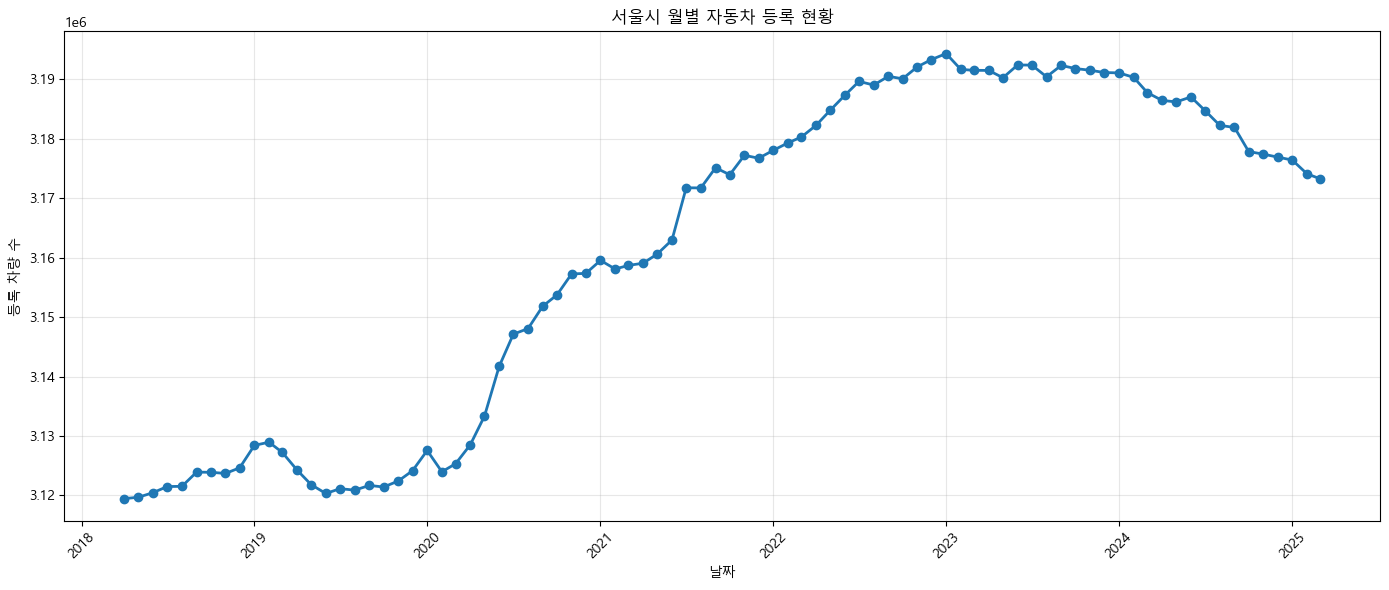

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv(
    "car_month_clean.csv",
    index_col="datetime",
    parse_dates=True
)

plt.figure(figsize=(14, 6))

plt.plot(
    df.index,
    df['car_count_month'],
    marker='o',
    linewidth=2
)

plt.title("서울시 월별 자동차 등록 현황")
plt.xlabel("날짜")
plt.ylabel("등록 차량 수")

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


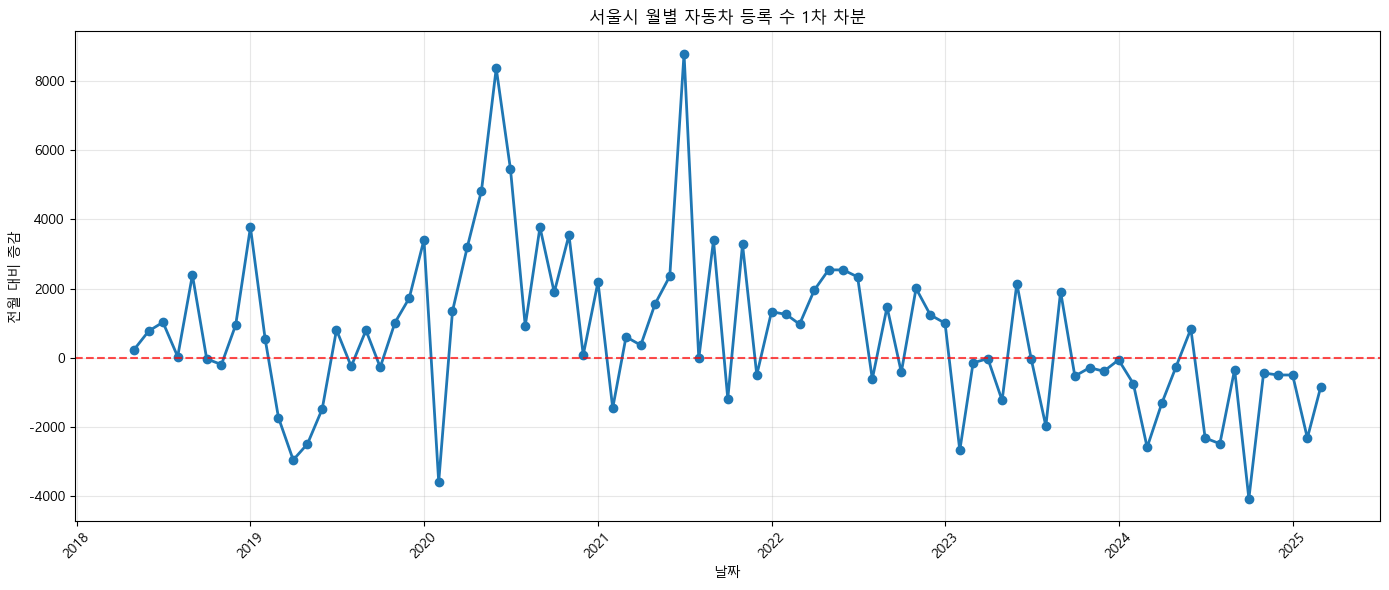

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv(
    "car_month_clean.csv",
    index_col="datetime",
    parse_dates=True
)

# 1차 차분
diff_1 = df['car_count_month'].diff()

plt.figure(figsize=(14, 6))
plt.plot(diff_1, marker='o', linewidth=2)

plt.title("서울시 월별 자동차 등록 수 1차 차분")
plt.xlabel("날짜")
plt.ylabel("전월 대비 증감")

plt.axhline(0, color='red', linestyle='--', alpha=0.7)  # 기준선
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

# 데이터 불러오기
df = pd.read_csv(
    "car_month_clean.csv",
    index_col="datetime",
    parse_dates=True
)

# 1차 차분
diff_1 = df['car_count_month'].diff().dropna()

# =====================
# ADF TEST
# =====================
adf_result = adfuller(diff_1)

print("ADF Test")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

# =====================
# KPSS TEST
# =====================
kpss_result = kpss(diff_1, regression='c', nlags='auto')

print("\nKPSS Test")
print(f"KPSS Statistic : {kpss_result[0]:.4f}")
print(f"p-value        : {kpss_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f"  {key}: {value:.4f}")


ADF Test
ADF Statistic : -3.6281
p-value       : 0.0052
Critical Values:
  1%: -3.5138
  5%: -2.8979
  10%: -2.5862

KPSS Test
KPSS Statistic : 0.5067
p-value        : 0.0402
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390


In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['car_count_month'], order=(1,1,1))
result = model.fit()

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:        car_count_month   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -762.219
Date:                Thu, 08 Jan 2026   AIC                           1530.437
Time:                        22:56:36   BIC                           1537.694
Sample:                    04-01-2018   HQIC                          1533.353
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7236      0.998      0.725      0.468      -1.232       2.680
ma.L1         -0.7232      0.999     -0.724      0.469      -2.681       1.235
sigma2      4.644e+06   1.45e-07    3.2e+13      0.0

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
for order in [(1,1,1), (2,1,1), (1,1,2)]:
    model = ARIMA(df['car_count_month'], order=order)
    result = model.fit()
    print(order, result.aic)


(1, 1, 1) 1530.437378132592
(2, 1, 1) 1534.0727931361032
(1, 1, 2) 1532.2447107243045


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

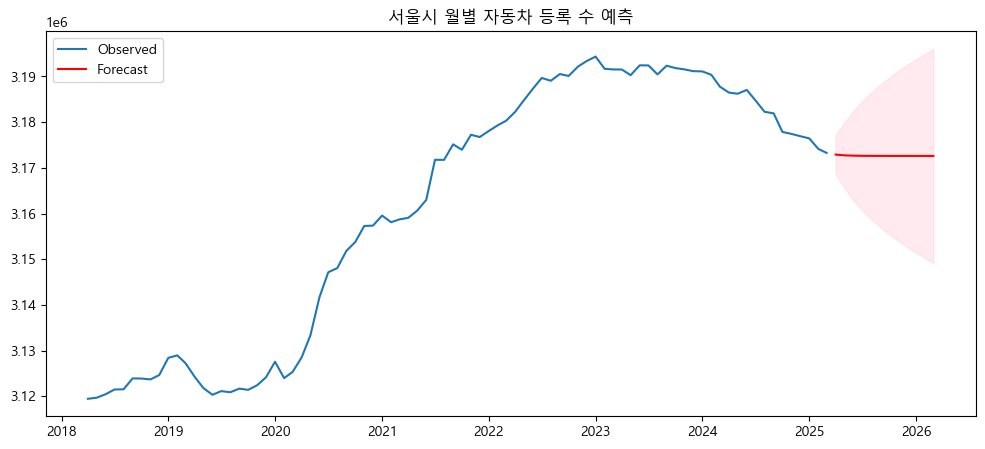

In [24]:
import matplotlib.pyplot as plt

forecast = result.get_forecast(steps=12)  # 12개월 예측
pred = forecast.predicted_mean
conf = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(df['car_count_month'], label='Observed')
plt.plot(pred.index, pred, label='Forecast', color='red')
plt.fill_between(conf.index,
                 conf.iloc[:,0],
                 conf.iloc[:,1],
                 color='pink', alpha=0.3)

plt.title('서울시 월별 자동차 등록 수 예측')
plt.legend()
plt.show()
